# Installing the qiskit and importing the libraries

In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

In [2]:
# Importing the necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import expm


import math
from math import pi,comb, floor

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit import  Parameter
from qiskit.visualization import *
from qiskit_aer import *

## Function for plotting quantum circuit

In [3]:
def qplot(x):
  return x.draw('mpl', initial_state = True, scale = 0.8, fold = False)

## Function for doing tensor product

In [4]:
def f(x,y):
  return np.kron(x,y)

## Some basic quantum operators

In [5]:
x = np.array([[0,1],[1,0]])                       # Pauli sigma X matrix
y = np.array([[0,-1j],[1j,0]])                    # Pauli sigma X matrix
z = np.array([[1,0],[0,-1]])                      # Pauli sigma X matrix
h = (1/np.sqrt(2))*np.array([[1,1],[1,-1]])       # Pauli sigma X matrix
cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
Ocnot = np.array([[0,1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]])
cz = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
swap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

zero = one = np.array([[1],[0]])                  # |0>
one = np.array([[0],[1]])                         # |1>
v = (1/2)*np.array([[1+1j,1-1j],[1-1j,1+1j]])     # qiskit sx gate; sqrt(x)
e = np.array([[1,0],[0,1]])

In [6]:
from qiskit.circuit.library import RYGate, GlobalPhaseGate

Let me consider the following Hamiltonian [[ref]](https://www.google.pl/books/edition/Quantum_Information_Science/UkbMEAAAQBAJ?hl=en&gbpv=1&dq=Riccardo+Manenti,+Mario+Motta+-+Quantum+Information+Science&printsec=frontcover)
$$\mathcal{H} =
\begin{pmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0 \\
\end{pmatrix}
$$
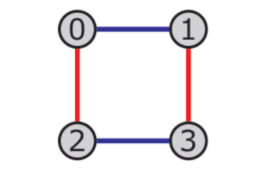

$$\mathcal{H} = \mathcal{H}_r + \mathcal{H}_b$$
where
- $$\mathcal{H}_r = |00⟩ ⟨10|+|10⟩ ⟨00|+|01⟩ ⟨11|+|11⟩ ⟨01|$$
- $$\mathcal{H}_b = |00⟩ ⟨01|+|01⟩ ⟨00|+|01⟩ ⟨11|+|11⟩ ⟨10|$$

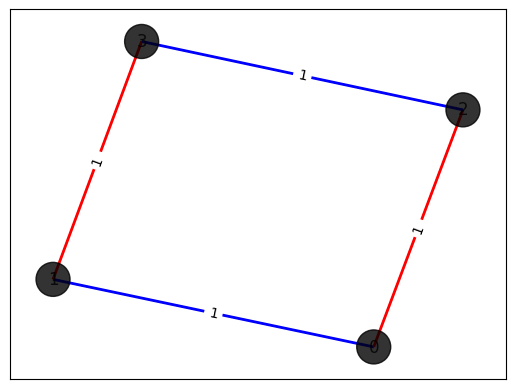

In [7]:
# Create the Graph associated to the Hamiltonian
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
elist = [(0, 1, 1), (0, 2, 1), (1, 3, 1), (2, 3, 1)]
G.add_weighted_edges_from(elist)

def draw_graph(G, node_colors, edge_colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=node_colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, ax=default_axes)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Set node colors and edge colors
node_colors = ["k" for node in G.nodes()]
edge_colors = ["b", "r", "r", "b"]  # Specify colors for edges

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph
draw_graph(G, node_colors, edge_colors, pos)

## Circuit Dynamics

Let us simulate the dynamics using three registers:

1. Main Register: 2-qubit
2. Ancillary Register: 2-qubit
3. Ancillary Register for matrix values : 1 qubit

We need to build $V_{\Delta t}$ that simulate the system evolution for time interval $\Delta t$

$$V_{\Delta t} = (V_b^\dagger \text{e}^{-iS\Delta t}V_b) (V_r^\dagger \text{e}^{-iS\Delta t}V_r)$$

where

$$V_c |a⟩|b⟩|z⟩=|a⟩|b\oplus v_c(a)⟩|z\oplus h_{a,v_c(a)}⟩ $$
we will put all ancillas equal to $|0⟩$ and simplify the $V_c$ like below

$$V_c |a⟩|00⟩|0⟩=|a⟩|v_c(a)⟩|h_{a,v_c(a)}⟩ $$

For this Hamiltonian we have following values for $v_c$ for colors red ($r$) and blue ($b$)

1. $v_r (0) = 2\quad \equiv (v_r (00) = 10)\quad ⟶ \qquad h_{0,v_r(0)} = h_{0,2} = 1 $
2. $v_r (1) = 3\quad \equiv(v_r (01) = 11)\quad ⟶ \qquad h_{1,v_r(1)} = h_{1,3} = 1 $
3. $v_r (2) = 0\quad \equiv(v_r (10) = 00)\quad ⟶ \qquad h_{2,v_r(2)} = h_{2,0} = 1 $
4. $v_r (3) = 1\quad \equiv(v_r (11) = 01)\quad ⟶ \qquad h_{3,v_r(3)} = h_{3,1} = 1 $

## Building the $V_r$ Operator

So now we are ready to design the operators $V_r$ and $V_b$. By using above values we can say

$$V_r|00⟩|00⟩|0⟩ = |00⟩|v_r(00)⟩|h_{0,2}⟩ = |00⟩|10⟩|1⟩ $$
$$V_r|01⟩|00⟩|0⟩ = |01⟩|v_r(01)⟩|h_{1,2}⟩ = |01⟩|11⟩|1⟩ $$
$$V_r|10⟩|00⟩|0⟩ = |10⟩|v_r(10)⟩|h_{2,0}⟩ = |10⟩|00⟩|1⟩ $$
$$V_r|11⟩|00⟩|0⟩ = |11⟩|v_r(11)⟩|h_{3,2}⟩ = |11⟩|01⟩|1⟩ $$

Now we should guess what the $V_r$ could be?
It is obvious the second ancillary qubit always is 1, then we can just put a $X$ gate there.
$$V_r = \text{CNOT}_{0,2}\text{CNOT}_{1,3}\text{X}_2\text{X}_4$$

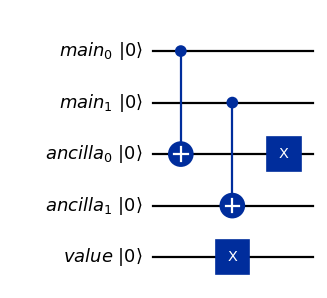

<IPython.core.display.Latex object>

In [8]:
qmain = QuantumRegister(2, name="main")
qa1 = QuantumRegister(2, name="ancilla")
qa2 = QuantumRegister(1, name="value")

cirq1 = QuantumCircuit(qmain, qa1, qa2)

# V_r
for i in range(2):
  cirq1.cx(qmain[i], qa1[i])

cirq1.x(qa2)
cirq1.x(qa1[0])
#cirq.barrier()

vr = cirq1.to_gate()
vr.name = "Vr"

vrdg = vr.inverse()

display(qplot(cirq1), Statevector(cirq1.reverse_bits()).draw('latex'))

## Building the $V_b$ Operator

## $v_c(a)$

1. $v_b (0) = 1\quad \equiv(v_b (00) = 01)\quad ⟶ \qquad h_{0,v_b(0)} = h_{0,1} = 1 $
2. $v_b (1) = 0 \quad \equiv(v_b (10) = 00)\quad ⟶ \qquad h_{1,v_b(0)} = h_{1,1} = 1 $
3. $v_b (2) = 3\quad \equiv(v_b (10) = 11)\quad ⟶ \qquad h_{2,v_b(0)} = h_{2,1} = 1 $
4. $v_b (3) = 2\quad \equiv(v_b (00) = 10)\quad ⟶ \qquad h_{3,v_b(0)} = h_{3,1} = 1 $

for $V_b$ we have the same
$$V_b|00⟩|00⟩|0⟩ = |00⟩|v_b(00)⟩|h_{0,1}⟩ = |00⟩|01⟩|1⟩ $$
$$V_b|01⟩|00⟩|0⟩ = |01⟩|v_b(01)⟩|h_{1,1}⟩ = |01⟩|00⟩|1⟩ $$
$$V_b|10⟩|00⟩|0⟩ = |10⟩|v_b(10)⟩|h_{2,1}⟩ = |10⟩|11⟩|1⟩ $$
$$V_b|11⟩|00⟩|0⟩ = |11⟩|v_b(11)⟩|h_{3,1}⟩ = |11⟩|10⟩|1⟩ $$

Now we should guess what the $V_b$ could be?
It is obvious the second ancillary qubit always is 1, then we can just put a $X$ gate there.
$$V_b = \text{CNOT}_{0,2}\text{CNOT}_{1,3}\text{X}_3\text{X}_4$$

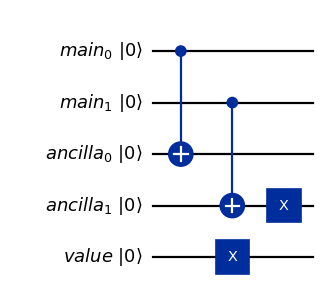

<IPython.core.display.Latex object>

In [9]:
cirq2 = QuantumCircuit(qmain, qa1, qa2)

# V_r
for i in range(2):
  cirq2.cx(qmain[i], qa1[i])

cirq2.x(qa2)
cirq2.x(qa1[1])
#cirq.barrier()

vb = cirq2.to_gate()
vb.name = "Vb"

vbdg = vb.inverse()

display(qplot(cirq2), Statevector(cirq2.reverse_bits()).draw('latex'))

## Building the $\text{e}^{-iS\Delta t}$ Operator

To implement $\text{e}^{-iS\Delta t}$ first we need to diagonalize the SWAP gate with a change of basis

$$\text{SWAP} =
 \begin{pmatrix}
 1 & 0  & 0 & 0 \\
 0 & 0  & 1 & 0 \\
 0 & 1  & 0 & 0 \\
 0 & 0  & 0 & 1 \\
 \end{pmatrix} $$
 We can make this gate diagonalize by using the following equation
 $$\text{SWAP} = W^\dagger D W $$

 where
$$ W =
 \begin{pmatrix}
 1 & 0  & 0 & 0 \\
 0 & 1/\sqrt{2}  & 1/\sqrt{2} & 0 \\
 0 & -1/\sqrt{2}  & 1/\sqrt{2} & 0 \\
 0 & 0  & 0 & 1 \\
 \end{pmatrix} \qquad
 D =
  \begin{pmatrix}
 1 & 0  & 0 & 0 \\
 0 & -1  & 0 & 0 \\
 0 & 0  & 1 & 0 \\
 0 & 0  & 0 & 1 \\
 \end{pmatrix}
 $$


we can decompose W based on the well-know quantum Gates

\begin{eqnarray}
 W &=& U_+^† CR_y(π/2) U_+   \\
&=&
\begin{pmatrix}
  1 & 0  & 0 & 0 \\
  0 & 0  & 0 & 1 \\
  0 & 0  & 1 & 0 \\
  0 & 1  & 0 & 0 \\
 \end{pmatrix}  
 \begin{pmatrix}
 1 & 0  & 0 & 0 \\
 0 & 1  & 0 & 0 \\
 0 & 0 & 1/\sqrt{2}  & 1/\sqrt{2}  \\
 0 & 0 & 1/\sqrt{2} & -1/\sqrt{2} \\
 \end{pmatrix}
 \begin{pmatrix}
  1 & 0  & 0 & 0 \\
  0 & 0  & 0 & 1 \\
  0 & 0  & 1 & 0 \\
  0 & 1  & 0 & 0 \\
 \end{pmatrix} \\
 &=&
 \begin{pmatrix}
 1 & 0  & 0 & 0 \\
 0 & 1/\sqrt{2}  & 1/\sqrt{2} & 0 \\
 0 & -1/\sqrt{2}  & 1/\sqrt{2} & 0 \\
 0 & 0  & 0 & 1 \\
 \end{pmatrix}
 \end{eqnarray}

 Where $U_+$ is just a circuit in which the target and control qubits have been changed.

### Building the $W$ gate

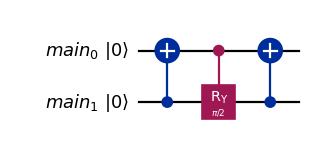

'W'

<IPython.core.display.Latex object>

'Wdg'

<IPython.core.display.Latex object>

In [10]:
cirq3 = QuantumCircuit(qmain)
cirq3.cx(1,0)
cirq3.cry(np.pi/2, 0,1)
cirq3.cx(1,0)

w = cirq3.to_gate()
w.name = "W"

wdg = w.inverse()

display(qplot(cirq3), "W" ,array_to_latex(Operator(cirq3.reverse_bits()).data), "Wdg" ,array_to_latex(Operator(cirq3.inverse().reverse_bits()).data))

## Building the $D$ gate

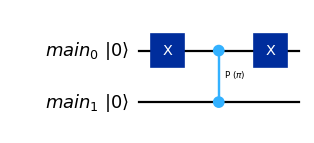

<IPython.core.display.Latex object>

In [11]:
# Matrix D
cirq4 = QuantumCircuit(qmain)
cirq4.x(0)
cirq4.cp(np.pi,0,1)
cirq4.x(0)

d = cirq4.to_gate()
d.name = "D"

display(qplot(cirq4), array_to_latex(Operator(cirq4.reverse_bits()).data))

### Checking the $ W^† D W =$ SWAP

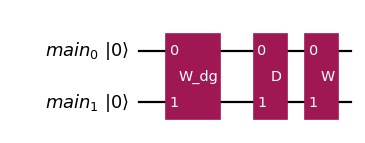

<IPython.core.display.Latex object>

In [12]:
cirq5 = QuantumCircuit(qmain)
cirq5.append(wdg,[0,1])
cirq5.append(d,[0,1])
cirq5.append(w,[0,1])


display(qplot(cirq5), array_to_latex(Operator(cirq5.reverse_bits()).data))

### Checking the $\text{e}^{-iS\Delta t}$
In the following circuit I just try to show for just a single SWAP gate how can we build $\text{e}^{-i(SWAP)\Delta t}$. To do this we can write it down as
$$\text{e}^{-i(SWAP)\Delta t} = W\text{e}^{-i(D)\Delta t} W^†$$

the only part that we should handle it is

$$\text{e}^{-i(D)\Delta t} =
\begin{pmatrix}
\text{e}^{-i\Delta t} & 0                    & 0                     & 0 \\
0                     & \text{e}^{i\Delta t} & 0                     & 0 \\
0                     & 0                    & \text{e}^{-i\Delta t} & 0 \\
0                     & 0                    & 0                     & \text{e}^{-i\Delta t} \\
\end{pmatrix}
= \text{e}^{-i\Delta t}
\begin{pmatrix}
1 & 0                     & 0 & 0 \\
0 & \text{e}^{i2\Delta t} & 0 & 0 \\
0 & 0                     & 1 & 0 \\
0 & 0                     & 0 & 1 \\
\end{pmatrix} $$
one can decompose this diagonal matrix just according to the control-phase gate
$$P(\theta) =
\begin{pmatrix}
1 & 0 \\
0 & \text{e}^{i\theta}
\end{pmatrix}$$


so for a controled-phase gate we just need to replace the control bit from $|0⟩$ into the $|1⟩$
$$|0⟩⟨0|⊗ P(2Δt) + |1⟩⟨1|⊗ \mathbb{I} =
\begin{pmatrix}
1 & 0                     & 0 & 0 \\
0 & \text{e}^{i2\Delta t} & 0 & 0 \\
0 & 0                     & 1 & 0 \\
0 & 0                     & 0 & 1 \\
\end{pmatrix} $$

In [13]:
# Matrix exp(-iDt)
def expD(t):
  circ = QuantumCircuit(qmain)
  circ.append(GlobalPhaseGate(-t))
  circ.x(0)
  circ.cp(2*t,0,1)
  circ.x(0)

  expd = circ.to_gate()
  d.name = "Exp(-iDΔt)"

  return expd

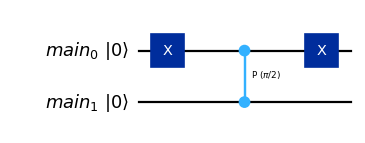

<IPython.core.display.Latex object>

In [14]:
circ6 = QuantumCircuit(qmain)
circ6.append(expD(np.pi/4), qmain)
display(qplot(circ6.decompose()), array_to_latex(Operator(circ6.reverse_bits()).data))

### Exact Simulation of $\text{e}^{-i (SWAP) t}$

In [15]:
t = np.pi/4
array_to_latex(expm(-1j*swap*t))

<IPython.core.display.Latex object>

### quantum circuit for $\text{e}^{-i (SWAP) t}$

In [16]:
def St(t):
  qmain = QuantumRegister(2, name="main")
  circ = QuantumCircuit(qmain)
  circ.append(wdg, [0,1])
  circ.append(expD(t),[0,1])
  circ.append(w, [0,1])

  S = circ.to_gate()
  S.name = "exp(-iS Δt)"

  return S

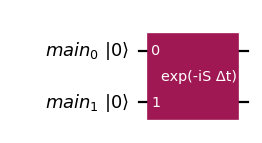

<IPython.core.display.Latex object>

In [17]:
circ7 = QuantumCircuit(qmain)
circ7.append(St(t), qmain)
display(qplot(circ7), array_to_latex(Operator(circ7.reverse_bits()).data))

## Building the the whole Block $V_{\Delta t}$

In [18]:
def vdt(t):
  qmain = QuantumRegister(2, name="main")
  qa1 = QuantumRegister(2, name="ancilla")
  qa2 = QuantumRegister(1, name="value")

  circ = QuantumCircuit(qmain, qa1, qa2)
  circ.append(vr, [i for i in range(5)])

  for i in range(2):
    circ.append(St(t), [qmain[i], qa1[i]])

  circ.append(vrdg, [i for i in range(5)])

  circ.append(vb, [i for i in range(5)])
  for i in range(2):
    circ.append(St(t), [qmain[i], qa1[i]])

  circ.append(vbdg, [i for i in range(5)])

  vdt = circ.to_gate()
  vdt.name = "VΔt"

  return vdt

# Final Circuit

## Exact Answer: `Scipy`

In [19]:
# parameters
T = 200*np.pi/7
m = 100
t = T/m
t

0.8975979010256552

In [20]:
hamiltonian = np.array([[0,1,1,0],[1,0,0,1],[1,0,0,1],[0,1,1,0]])
array_to_latex(expm(-1j*hamiltonian * T))

<IPython.core.display.Latex object>

In [21]:
qmain = QuantumRegister(2, name="main")
qa1 = QuantumRegister(2, name="ancilla")
qa2 = QuantumRegister(1, name="value")
cbits = ClassicalRegister(3)
circuit = QuantumCircuit(qmain, qa1, qa2, cbits)

for i in range(m):
  circuit.append(vdt(t), [i for i in range(5)])

Statevector(circuit.reverse_bits()).draw('latex')
#display(qplot(circuit.decompose(reps=1)), Statevector(circuit.reverse_bits()).draw('latex'))

<IPython.core.display.Latex object>

### Measurement

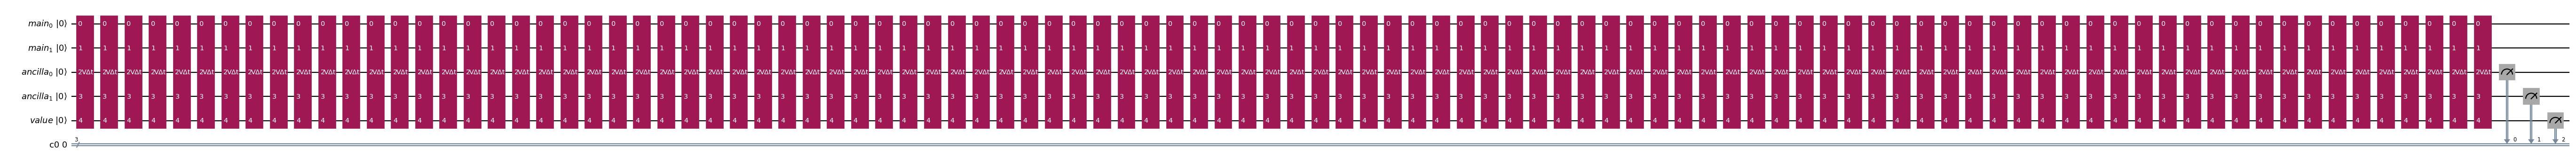

In [22]:
circuit.measure([2,3,4], cbits)
#circuit.measure_all()
qplot(circuit)

## Simulation with `StatevectorSimulaton`

In [48]:
backend = StatevectorSimulator()
trans_circ = transpile(circuit, backend)
job = backend.run(trans_circ)
result = job.result()
measured_sv = result.get_statevector()

In [24]:
measured_sv.draw('latex')

<IPython.core.display.Latex object>

The amplitudes in this case are complex numbers due to the presence of a global phase in the quantum circuit. This global phase, however, does not affect the final outcome of the measurement. In the following cell, I have demonstrated the norm of these complex numbers to highlight this property.

In [45]:
for i in range(4):
  print(f"i={i}, and probability is   ", np.linalg.norm(measured_sv[i]))


i=0, and probability is    0.049515566048787985
i=1, and probability is    0.21694186955877479
i=2, and probability is    0.21694186955877312
i=3, and probability is    0.9504844339512121


## Simulation of $\mathcal{H}$: Second Approach

We can check the numbers that we achieved in our simulation with exact solution of this Hamiltonian


Note that this Hamiltonian can be simulated in a much more efficient way: one can decompose $H$ in the Pauli basis:

\begin{eqnarray}
    H = I \otimes \sigma_x + \sigma_x \otimes I,
\end{eqnarray}

and simulate the dynamics by applying two single-qubit rotations to a register of two qubits:

\begin{eqnarray}
    U_t = e^{-i(I \otimes \sigma_x + \sigma_x \otimes I)t} = R_x(2t) \otimes R_x(2t).
\end{eqnarray}

the output state for the $V_t$

\begin{eqnarray}
    U_{\Delta t}|00⟩ &=& R_x(2\Delta t) \otimes R_x(2\Delta t) |00⟩ \nonumber\\
    &=& \cos^2{\Delta t} |00⟩ -2i\sin{\Delta t}\cos{\Delta t} (|01⟩+|10⟩) - \sin^2{\Delta t} |11⟩
\end{eqnarray}


In [47]:
circuit1 = QuantumCircuit(2)
for i in range(m):
  circuit1.rx(2*t,0)
  circuit1.rx(2*t,1)

#display(qplot(circuit1), array_to_latex(Operator(circuit1).data), Statevector(circuit1.reverse_bits()).draw('latex'))
Statevector(circuit1.reverse_bits()).draw('latex')

<IPython.core.display.Latex object>

In [50]:
array_to_latex(Operator(circuit1).data)

<IPython.core.display.Latex object>

However we knew for this kind of Hamiltonian that two parts commute with each other we don't need to use Suzuki-Trotter Decomposition. The following code shows this fact

In [49]:
circuit2 = QuantumCircuit(2)
circuit2.rx(2*T,0)
circuit2.rx(2*T,1)

Statevector(circuit2.reverse_bits()).draw('latex')

<IPython.core.display.Latex object>